In [1]:
import csv
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
from time import time
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.externals import joblib

<i>I had started this project some time before I registered at GitHub, that is why most of the changes history is lost. Note that this file is still being developed.</i>

The abalone dataset comes from an original (non-machine-learning) study: Warwick J Nash -  "The Population Biology of Abalone...". This is a classification problem. The goal was to predict the age of an abalone, given its sex and laboratory measurements such as length or viscera weight. The notebook shows subsequent steps of my very own full data science project, together with the comments explaining each cell written. I described in detail each of the smaller tasks such as data exploration, implementing two supervised learning algorithms, dimensionality reduction and hyperparameter tuning using cross-validation. I also compared my results with the ones achieved by the previous authors mentioned in the abalone_names.txt file.

***
# 1. Data exploration


I started with downloading the abalone dataset and edited it in MS Excel: added the headers based on the abalone.names file and converted it to the .csv format. Then I loaded it in Python using pandas module:

In [5]:
df = pd.read_csv('abalone_data.csv')
df.head()

,Sex,Length [mm],Diameter [mm],Height [mm],Whole weight [g],Shucked weight [g],Viscera weight [g],Shell weight [g],Number of rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


In [6]:
df.shape

(4177, 9)

It appears that the data has been loaded correctly. Each row represents all the measurements and the number of rings of a single abalone, while each column corresponds to all the measurements of a given feature (e.g. the diameter of each abalone). 

In [7]:
df.isnull().values.any()

False

Fortunately there are no missing values in the dataset. Now let's take a look at the data structure:

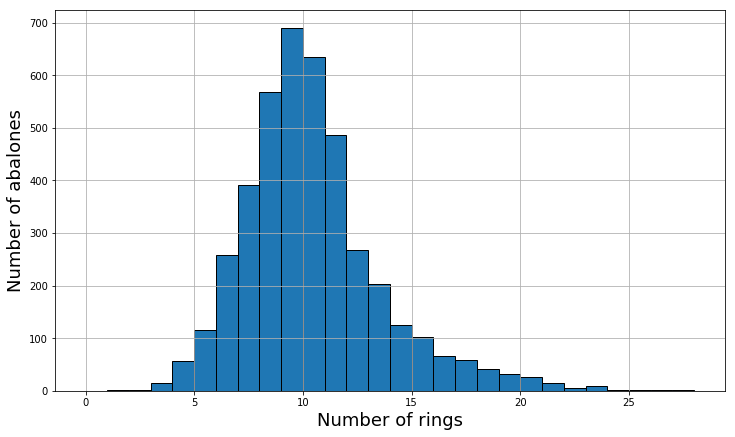

In [8]:
%matplotlib inline
plt.figure(figsize = (12,7))
plt.grid()
plt.xlabel("Number of rings", fontsize = 18)
plt.ylabel("Number of abalones", fontsize = 18)
max_rings = df['Number of rings'].max()
plt.hist(df['Number of rings'], bins = [k for k in range(max_rings)], ec='black')
plt.show()

One can see that this is a heavy-tailed distribution. To see the exact numbers I am going to make a summary of the numerical attributes:

In [9]:
df.describe()

,Length [mm],Diameter [mm],Height [mm],Whole weight [g],Shucked weight [g],Viscera weight [g],Shell weight [g],Number of rings
count,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000
mean,0.523992,0.407881,0.139516,0.828742,0.359367,0.180594,0.238831,9.933684
std,0.120093,0.099240,0.041827,0.490389,0.221963,0.109614,0.139203,3.224169
min,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,1.000000
25%,0.450000,0.350000,0.115000,0.441500,0.186000,0.093500,0.130000,8.000000
50%,0.545000,0.425000,0.140000,0.799500,0.336000,0.171000,0.234000,9.000000
75%,0.615000,0.480000,0.165000,1.153000,0.502000,0.253000,0.329000,11.000000
max,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000,29.000000


One can see that at least half of the abalones fall within the range from 8 to 11 rings inclusive, which can estimate the age of the majority between 9,5 and 12,5 years. Since the number of samples of the abalones with more than 21-22 and less than 3 rings is very small, the measurements may not be representative for the oldest and the youngest of them. 

The values of the attributes generally look suspicious: for example mean length of an abalone being as small as 0.5 mm. This is explained in the txt file, saying that the values have already been scaled for use with an artificial neural network (by dividing by 200).

The dataset is not that big, so one can compute the Pearson correlation coefficient between the number of rings and every other attribute:

In [10]:
corr_matrix = df.corr()
corr_matrix["Number of rings"].sort_values(ascending=False)

Number of rings       1.000000
Shell weight [g]      0.627574
Diameter [mm]         0.574660
Height [mm]           0.557467
Length [mm]           0.556720
Whole weight [g]      0.540390
Viscera weight [g]    0.503819
Shucked weight [g]    0.420884
Name: Number of rings, dtype: float64

As expected, all of the attributes are positively correlated with the number of rings. What is more, plotting the scatter matrix proves there is a strong correlation between any two attributes of this dataset:

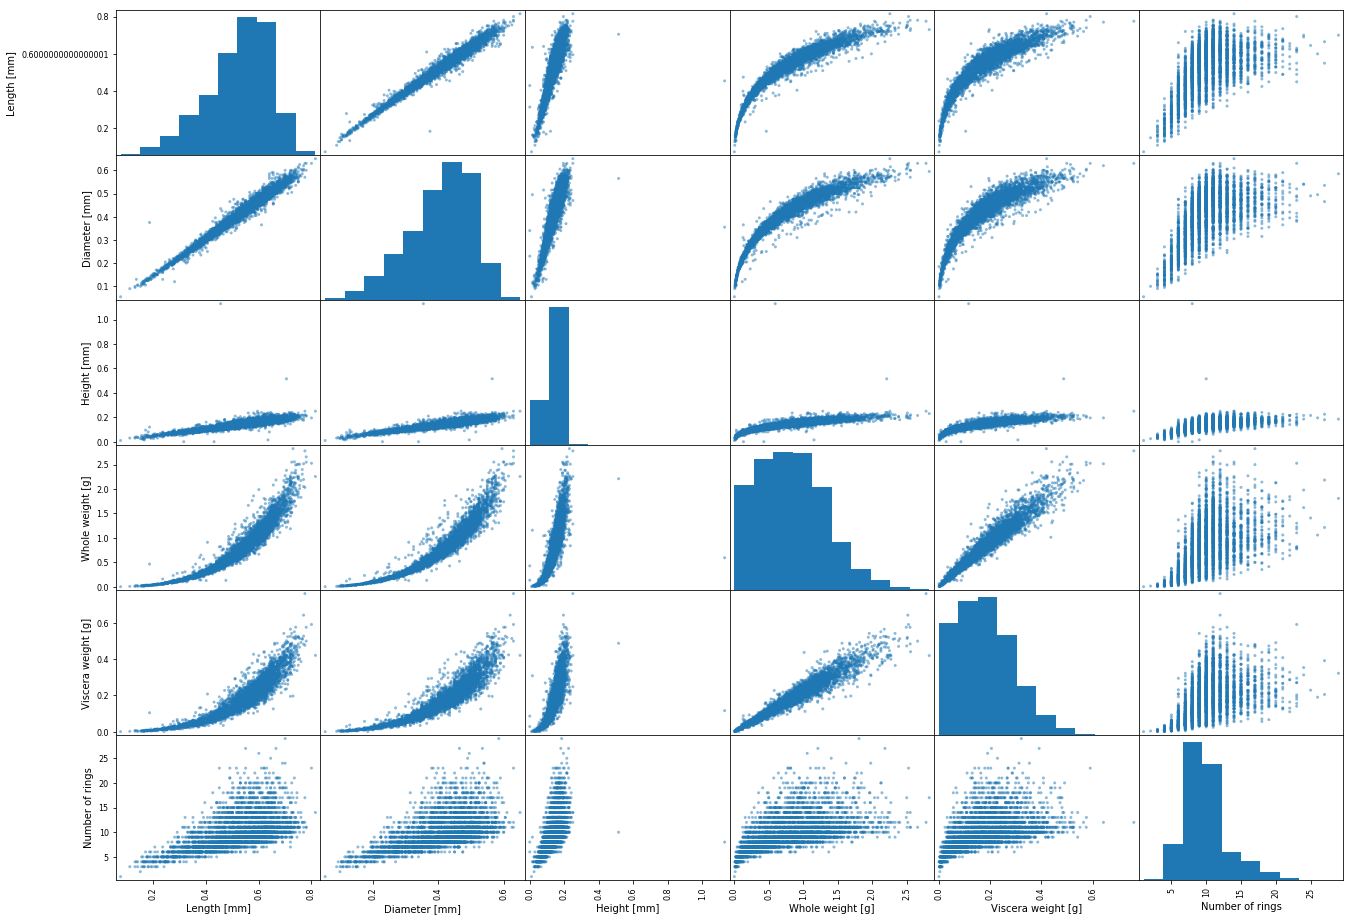

In [11]:
attributes_to_plot = df[['Length [mm]', 'Diameter [mm]', 'Height [mm]', 'Whole weight [g]', 'Viscera weight [g]', 'Number of rings']]
scatter_matrix(attributes_to_plot, figsize = (22,16))
plt.show()

I also decided to take a closer look at some of the plots and colour the points in three different ways, according to the sex of an abalone, to find out if that matters.

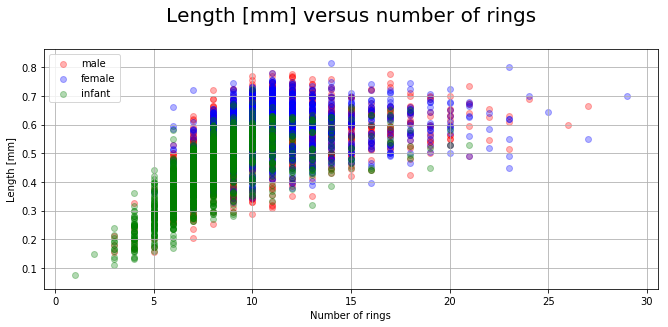

In [15]:
alpha = 0.3
plt.figure(figsize=(10,7))
plt.subplots_adjust(right=2, top=0.6, wspace=0.2)
plt.subplot(1,2,1)
plt.grid()
plt.title("Length [mm] versus number of rings\n", fontsize = 20)
plt.xlabel('Number of rings')
plt.ylabel('Length [mm]')
plt.scatter(df.loc[df.Sex == 'M', 'Number of rings'], df.loc[df.Sex == 'M', 'Length [mm]'], c = 'r', label = 'male', alpha = alpha)
plt.scatter(df.loc[df.Sex == 'F', 'Number of rings'], df.loc[df.Sex == 'F', 'Length [mm]'], c = 'b', label = 'female', alpha = alpha)
plt.scatter(df.loc[df.Sex == 'I', 'Number of rings'], df.loc[df.Sex == 'I', 'Length [mm]'], c = 'g', label = 'infant', alpha = alpha)
plt.legend(loc = 'upper left')
plt.show()

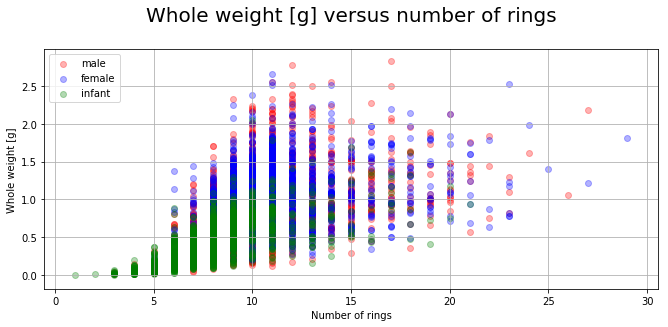

In [13]:
alpha = 0.3
plt.figure(figsize=(10,7))
plt.subplots_adjust(right=2, top=0.6, wspace=0.2)
plt.subplot(1,2,1)
plt.grid()
plt.title("Whole weight [g] versus number of rings\n", fontsize = 20)
plt.xlabel('Number of rings')
plt.ylabel('Whole weight [g]')
plt.scatter(df.loc[df.Sex == 'M', 'Number of rings'], df.loc[df.Sex == 'M', 'Whole weight [g]'], c = 'r', label = 'male', alpha = alpha)
plt.scatter(df.loc[df.Sex == 'F', 'Number of rings'], df.loc[df.Sex == 'F', 'Whole weight [g]'], c = 'b', label = 'female', alpha = alpha)
plt.scatter(df.loc[df.Sex == 'I', 'Number of rings'], df.loc[df.Sex == 'I', 'Whole weight [g]'], c = 'g', label = 'infant', alpha = alpha)
plt.legend(loc = 'upper left')
plt.show()

The natural fact is the older the abalones, the bigger they are - both in terms of weight and geometric measurements. Similiar analysis can be done for other features, like height or viscera weight. At first I thought an abalone is considered an infant up to a certain age - but the plots show that there are infants with 20 or even 21 rings, they just weigh less and are shorter than the other abalones of the same age. On the other hand, male and female abalones do not differ much from each other. There are single units of both sex which are slighty bigger or slightly smaller than the rest of the population.

Another idea is to plot their length versus diameter:

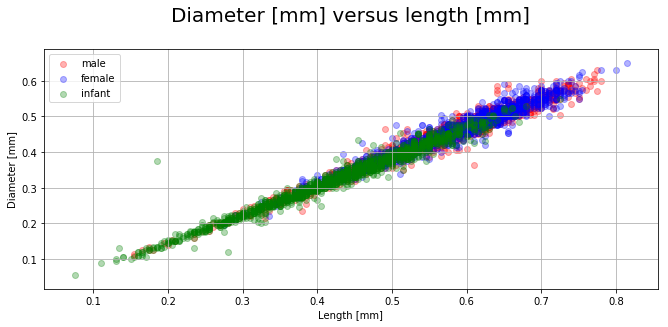

In [14]:
alpha = 0.3
plt.figure(figsize=(10,7))
plt.subplots_adjust(right=2, top=0.6, wspace=0.2)
plt.subplot(1,2,1)
plt.grid()
plt.title("Diameter [mm] versus length [mm]\n", fontsize = 20)
plt.xlabel('Length [mm]')
plt.ylabel('Diameter [mm]')
plt.scatter(df.loc[df.Sex == 'M', 'Length [mm]'], df.loc[df.Sex == 'M', 'Diameter [mm]'], c = 'r', label = 'male', alpha = alpha)
plt.scatter(df.loc[df.Sex == 'F', 'Length [mm]'],df.loc[df.Sex == 'F', 'Diameter [mm]'], c = 'b', label = 'female', alpha = alpha)
plt.scatter(df.loc[df.Sex == 'I', 'Length [mm]'], df.loc[df.Sex == 'I', 'Diameter [mm]'], c = 'g', label = 'infant', alpha = alpha)
plt.legend(loc='upper left')
plt.show()

Which, interestingly, shows almost perfect linear correlation between those two. It does not matter if an abalone is young, old, male, female or even an infant - their shape is almost the same through their whole life, they just grow in size. There is one green outlier here that clearly stands out. <span style="color:red">Future reference: what to do with the outlier?</span>

Lastly, their whole weight versus length:

[]

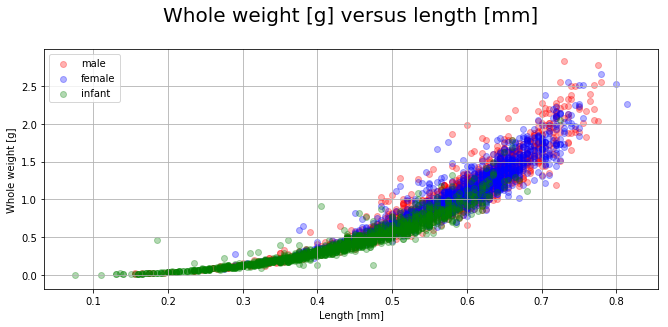

In [17]:
alpha = 0.3
plt.figure(figsize=(10,7))
plt.subplots_adjust(right=2, top=0.6, wspace=0.2)
plt.subplot(1,2,2)
plt.grid()
plt.title("Whole weight [g] versus length [mm]\n", fontsize = 20)
plt.xlabel('Length [mm]')
plt.ylabel('Whole weight [g]')
plt.scatter(df.loc[df.Sex == 'M', 'Length [mm]'], df.loc[df.Sex == 'M', 'Whole weight [g]'], c = 'r', label = 'male', alpha = alpha)
plt.scatter(df.loc[df.Sex == 'F', 'Length [mm]'], df.loc[df.Sex == 'F', 'Whole weight [g]'], c = 'b', label = 'female', alpha = alpha)
plt.scatter(df.loc[df.Sex == 'I', 'Length [mm]'], df.loc[df.Sex == 'I', 'Whole weight [g]'], c = 'g', label = 'infant', alpha = alpha)
plt.legend(loc = 'upper left')
plt.plot()

This looks more like a power than linear relationship - which is rather natural, as weight is a function of volume, which is the multiplication of lengths in several dimensions. This might be considered later in the process of feature engineering.

# 2. Supervised learning

I am going to apply try two different approaches just like the authors: first I am going to penalize the algorithms for not predicting the exact number of rings and reward it only when they get it right, and then I will create three different bins of rings: up to 8, 9 or 10 and 11 or more. The two algorithms chosen for this task are k-nearest neighbors and random forest.

In the first place I am going to prepare the data. As the rows with missing values has already been removed there is no need to do that. The goal is to split the data into the matrix of features (X) and the vector of ground-truth values for each abalone (y - the number of rings) to use them later for training and test purposes. A single row in the matrix corresponds to all the features of a single abalone and a single column to a single feature of all the abalones e.g. whole weight.

The main problem now is the sex attribute which is of the string type. Converting it to interers like M = 0, F = 1 and I = 2 would not be good, because it would mean to the classification algorithms that somehow an infant is 'more important' than a male or a female, or that there is a bigger difference between a male and an infant than between a female and an infant. Instead I created three new columns in the X matrix: is_male, is_female and is_infant, value of 1 meaning this is the sex of a given abalone. This way I increased the total number of features, but made sure they are all 'equal'.

In [21]:
features = ['Sex', 'Length [mm]', 'Diameter [mm]', 'Height [mm]', 'Whole weight [g]','Shucked weight [g]',
       'Viscera weight [g]', 'Shell weight [g]']
X = df[features]
y = df['Number of rings']

sex_df = pd.Categorical(X['Sex'])
XDummies = pd.get_dummies(sex_df, prefix = 'Sex')
X = pd.concat([X, XDummies], axis=1)
X.drop('Sex', axis=1, inplace=True)
X.head()

,Length [mm],Diameter [mm],Height [mm],Whole weight [g],Shucked weight [g],Viscera weight [g],Shell weight [g],Sex_F,Sex_I,Sex_M
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,0,0,1
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,0,0,1
2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,1,0,0
3,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,0,0,1
4,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,0,1,0


At this moment we have the matrix X and vector y in the right forms, ready to start some calculations. Inspired by the past usage of this database, I split them into two sets: 75% of the examples became the training set and the other 25% the test set, to avoid trying to memorize the dataset by the model. As the first algorithm, I used the simpler of the two models: k-nearest neighbors. The random forest may have higher accuracy, but at the expense of interpretability.

KNN algorithm tries to classify the new object (one from the test data) as a member of the class corresponding to its k-nearest neighbours (the training points). For k = 1, it will simply become the class of the nearest neighbour. For k > 1, the class is chosen among the most common of the nearest neighbours. The default metric in sklearn for this algorithm is minkowski, which, with the other default parameters, is equivalent to the standard Euclidean metric. When a new data row describing a single abalone is given with an intention to predict the rings value, the algorithm iterates through all the training points and tries to find the nearest ones in terms of the mentioned metric. For the first try, I chose the k-value of 5.

In [22]:
#splitting the data in the training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

#implementing the KNN algorithm
knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(X_train, y_train)

#making predictions based on the training and test inputs
y_pred = knn.predict(X_test)
y_pred_train = knn.predict(X_train)

print('k-nn test accuracy: ' + str(round(metrics.accuracy_score(y_test, y_pred)*100, 2)) + '%.')
print('k-nn training accuracy: ' + str(round(metrics.accuracy_score(y_train, y_pred_train)*100, 2)) + '%.')

k-nn test accuracy: 23.06%.
k-nn training accuracy: 44.7%.


For the test set, I got about 23% accuracy, which, I would say, is satisfactory considering the fact this is not an easy classification problem with 29 different classes and the k parameter is not yet optimized. In task 5 I will try to optimize it, as for higher values of k in KNN the model is less complicated and better at generalizing the data. For now it is greatly overfitting the problem.

The next observation is that the results would be a lot better if (like the past authors scores mentioned in the documentation) we would consider this problem as 3-category classification (grouping together rings 1-8, 9-10 and 11 and more). I copied and edited the original y vector, so that 0 corresponds to 1-8 rings, 1 to 9 or 10 and 2 to 11 or more.

In [23]:
y_new = y.copy()

for i in range(len(y_new)):
    if y_new[i] in range(1, 9):
        y_new[i] = 0
    elif (y_new[i] == 9 or y_new[i] == 10):
        y_new[i] = 1
    else:
        y_new[i] = 2

Now one can check the accuracy in this 3-category classification problem:

In [42]:
X_train, X_test, y_new_train, y_new_test = train_test_split(X, y_new, test_size = 0.25, random_state = 42)

knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(X_train, y_new_train)
y_pred = knn.predict(X_test)
y_pred_train = knn.predict(X_train)

print('k-nn test accuracy: ' + str(round(metrics.accuracy_score(y_new_test, y_pred)*100, 2)) + '%.')
print('k-nn training accuracy: ' + str(round(metrics.accuracy_score(y_new_train, y_pred_train)*100, 2)) + '%.')

k-nn test accuracy: 64.21%.
k-nn training accuracy: 73.98%.


For k = 5 the results are almost identical to the ones achieved by Waugh, 1995.

From now to the end, I will focus only on the harder problem. The second algorithm I am going to use and which is great for classification tasks is a random forest, again from the sklearn module.

Random forest is an ensemble learning method, meaning it uses other multiple machine learning algorithms - decision trees. Decision tree is a flowchart-like structure with the nodes where each of them represents a test on one of the attributes, e.g. it checks whether the length of a particular abalone is lower or greater than 0.5 mm. The possible paths which can be taken represent classification rules. 

One decision tree is not that good for machine learning tasks and would probably perform worse than the KNN. Random forests are a way of averaging multiple deep decision trees, where each of them "votes" on the final result and the most frequent option is chosen.

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

forest = RandomForestClassifier(n_estimators=100, random_state = 42)
forest.fit(X_train, y_train) 
y_pred = forest.predict(X_test)
y_pred_train = forest.predict(X_train)
print('random forest test accuracy: ' + str(round(metrics.accuracy_score(y_test, y_pred)*100, 2)) + '%.')
print('random forest training accuracy: ' + str(round(metrics.accuracy_score(y_train, y_pred_train)*100, 2)) + '%.')

random forest test accuracy: 25.17%.
random forest training accuracy: 100.0%.


The random forest performed better than the KNN, although without the max_depth model parameter it memorized the whole training set, resulting in 100% training accuracy. This will be optimized later, again to reduce overfitting the data.

# 3. Dimensionality reduction

Dimensionality reduction is most useful when each of the data examples consists of hundreds (or thousand) of features. Then not only is the learning slow, but also it is often hard to find a good solution as it can make the model very complicated. As the features are usually highly correlated with each other or irrelevant at all, we do not lose much information by dimensionality reduction and we speed up the learning process.

A perfect example to applicate the dimensionality reduction would be the well known MNIST dataset of handwritten digits: as the features are the greyscale values and the image is 28x28 pixels, we have got 784 dimensions. But by assuming the corner pixels are always irrelevant to the classification problem and as any two adjecent pixels are usually correlated, by taking the mean greyscale value we can reduce the number of dimensions several times.
Dimensionality reduction is also helpful for visualizing the data with many dimensions, as we humans have problems with more than three - surely we live in just three-dimensional space!

I am going to use SelectKBest from sklearn, with the Chi-Squared chosen as the statistical test. SelectKBest will compute it between each feature of X and y - a small value will mean the feature is independent of y and a large value will mean that this certain feature probably contain some important information, and this way the most relevant features will be selected.

In [45]:
test = SelectKBest(score_func=chi2, k=5)
fit = test.fit(X, y)
X_selected = fit.transform(X)
print(X_selected)
print('\n', X_selected.shape)

[[0.514  0.2245 0.     0.     1.    ]
 [0.2255 0.0995 0.     0.     1.    ]
 [0.677  0.2565 1.     0.     0.    ]
 ...
 [1.176  0.5255 0.     0.     1.    ]
 [1.0945 0.531  1.     0.     0.    ]
 [1.9485 0.9455 0.     0.     1.    ]]

 (4177, 5)


It is worth mentioning that the SelectKBest algorithm chose weights and the sex getting rid of the geometric measurements like the length or the diameter. But, as we saw earlier, all of the features are somehow dependent on each other, for example whole weight being a power function of length.

Now, to compare the accuracy and execution time (as for KNN, most of the time is actually not the fitting, but the output prediction), I am going to measure the time taken by each of the algorithms for two different feature matices - the original one and the one selected by SelectKBest. I ran each algorithm for 100 times and took the mean of accuracies.

In [46]:
#original feature matrix
accuracies_orig = []

t0 = time()
for i in range(100):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25) 
    knn = KNeighborsClassifier(n_neighbors = 5)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    accuracies_orig.append(metrics.accuracy_score(y_pred, y_test)*100)
t1 = time()

print('Accuracy for the original feature matrix: ' + str(round(np.mean(accuracies_orig), 2)) + '%.')
print('Time taken: ' + str(round(t1 - t0, 3)) + 's.')

Accuracy for the original feature matrix: 23.28%.
Time taken: 1.887s.


In [47]:
#selected feature matrix
accuracies_sel = []

t0 = time()
for i in range(100):
    X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size = 0.25) 
    knn = KNeighborsClassifier(n_neighbors = 5)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    accuracies_sel.append(metrics.accuracy_score(y_pred, y_test)*100)
t1 = time()

print('Accuracy for the selected feature matrix: ' + str(round(np.mean(accuracies_sel), 2)) + '%.')
print('Time taken: ' + str(round(t1 - t0, 3)) + 's.')

Accuracy for the selected feature matrix: 22.81%.
Time taken: 1.166s.


There is almost no difference in the model accuracy, so we have not lost any significant data by feature selection. There is also a small time improvement when the feature matrix width is reduced from 10 to 5 - the process is almost 2 times faster. The difference would be bigger if the dimensionality reduction had been done for example from thousands to hundreds or if a different supervised algorithm had been used.

Another common pick used in dimensionality reduction is called Principal Component Analysis. Basically PCA creates a hyperplane and then projects all the data points onto it. It can be compared to projecting the points in two-dimensional space onto a single line. The PCA algorithm tries to find such hyperplane, that the projected polints will have maximum variance - and, therefore, the least possible amount of information will be lost in the process.

Going more into details, there is a technique of matrix factorization called sinular value decomposition. The class PCA from the sklearn module implements the PCA analysis using the SVD, in order to find such axes, so the projected points will have maximum variance. Fortunately, sklearn makes it very simple to apply: all I have to do is pass it the number of dimensions I want to finally have in X matrix.

In [33]:
#checking the impact of the number of PCA dimensions on the accuracy and time taken to execute
times = []
dimensions_accuracy = []

#loop for dimensions from 1 to 10
for j in range(1, 11):
    accuracies_train = []
    pca = PCA(n_components = j)
    X_projected = pca.fit_transform(X)
    
    #measuring time, training KNN model for each X_projected matrix
    t0 = time()
    for i in range(100):
        X_train, X_test, y_train, y_test = train_test_split(X_projected, y, test_size = 0.25)
        knn = KNeighborsClassifier(n_neighbors = 5)
        knn.fit(X_train, y_train)
        y_pred = knn.predict(X_test)
        accuracies_train.append(metrics.accuracy_score(y_pred, y_test))
    t1 = time()
    
    #appending the dimensions_accuracy and times list for every dimensions value
    dimensions_accuracy.append(round(np.mean(accuracies_train), 3))
    times.append(round(t1 - t0, 2))

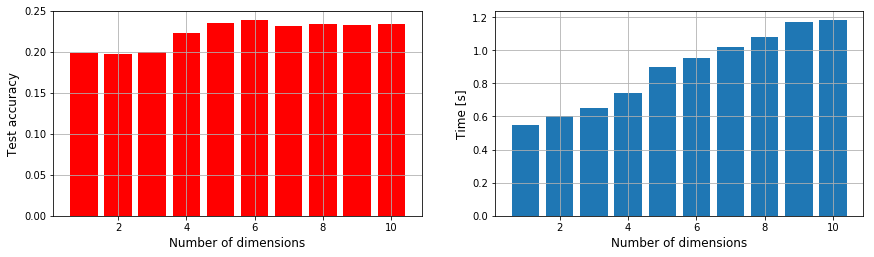

In [34]:
#now to plot the results
dimensions = [i for i in range(1,11)]
plt.figure(figsize=(6,6))
plt.subplots_adjust(right=2, top=0.6, wspace=0.2)
plt.subplot(1,2,1)
plt.grid()
plt.bar(dimensions, dimensions_accuracy, color = 'r')
plt.xlabel('Number of dimensions', fontsize = 12)
plt.ylabel('Test accuracy', fontsize = 12)

plt.subplot(1,2,2)
plt.grid()
plt.bar(dimensions, times)
plt.xlabel('Number of dimensions', fontsize = 12)
plt.ylabel('Time [s]', fontsize = 12)
plt.show()

Of course the time gets lower as we project the points onto lower dimension hyperplanes, as it takes less computations to train the model and predict the outputs when there are less columns in the feature matrix. The accuracy stays almost the same. There is a small drop comparing 3 to 4 dimensions, but still the model is able to maintain about 25% even when the points are projected onto a single one-dimensional line. 

# 4. Hyperparameter selection and crossvalidation

In [78]:
pca = PCA(n_components = 6)
X_projected = pca.fit_transform(X)

SPLIT THE DATA INTO TRAINING (WHICH HAS EVALUATION INSIDE) AND TEST SET

There is a problem with cross-validation on this dataset: when the data is split into K folds, the classes should be represented with equal proportions in each of the K folds. As we do not have enough examples of the youngest and the oldest abalones, sklearn will produce a warning when trying to divide the data.

Anyway, I chose to ignore the warning and started with optimizing the hyperparameter for the k-nearest neighbors algorithm using cross-validation. The cross_val_score function in the for loop below uses one fold as the test set and the rest as the training set, which is then repeated for every fold (10 times for each value of k). It returns a list of accuracies for the certain k value and then the mean of them is added to knn_accuracies_test list.

In [107]:
#hiding the warnings about the minimum number of members in classes when splitting the data using cross-validation
warnings.filterwarnings("ignore", category=Warning) 

#creating a list of reasonable k values to look for the best for the model
k_list = [k for k in range(1,101)]
knn_accuracies_test = []

#searching for the optimal value of k
for k in k_list:
    knn = KNeighborsClassifier(n_neighbors = k)
    knn_accuracies = cross_val_score(knn, X_projected, y, cv = 10, scoring = 'accuracy')
    knn_accuracies_test.append(knn_accuracies.mean())

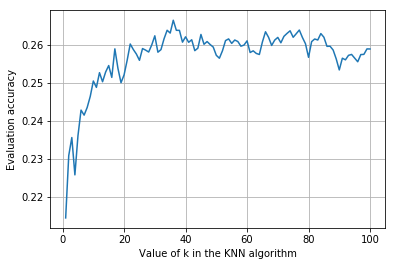

In [109]:
plt.plot(k_list, knn_accuracies_test)
plt.grid()
plt.xlabel('Value of k in the KNN algorithm')
plt.ylabel('Evaluation accuracy')
plt.show()

In [110]:
k_max = knn_accuracies_test.index(max(knn_accuracies_test)) + 1
print('The best test accuracy: ' + str(round(max(knn_accuracies_test)*100, 2)) + 
      '%, for k = ' + str(k_max) + '.')

The best test accuracy: 26.65%, for k = 36.


The result is pretty good - optimizing the k parameter happened to increase the initial model test accuracy (for k = 5) from around 23% to 26%. Finally I would like to plot the training vs test accuracy for different k values:

In [111]:
X_train, X_test, y_train, y_test = train_test_split(X_projected, y, test_size = 0.25)
k_list = [k for k in range(1,101)]
knn_accuracies_train = []

for k in k_list:
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train, y_train)
    y_pred_train = knn.predict(X_train)
    knn_accuracies_train.append(metrics.accuracy_score(y_pred_train, y_train))

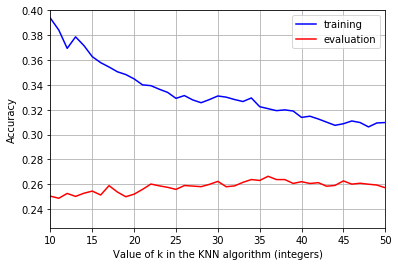

In [106]:
plt.xlabel('Value of k in the KNN algorithm (integers)')
plt.ylabel('Accuracy')
plt.grid()
plt.axis((10,50,0.225,0.4))
plt.plot(k_list, knn_accuracies_train, 'b', label='training')
plt.plot(k_list, knn_accuracies_test, 'r', label='test')
plt.legend(loc='upper right')
plt.show()

It is slightly visible just by looking at this plot - around k = 36 the test accuracy in fact starts to decrease, thus at k = 41 the model is the best at generalizing data and finding the relationship between the measurements and the number of rings. When k is small, the model is trying to memorize the training data (overfitting) and when k is big, the model is not complex enough (underfitting).

In [112]:
final_knn = KNeighborsClassifier(n_neighbors = 36)
joblib.dump(final_knn, 'knn_classifier.pkl')

['knn_classifier.pkl']

For the random forest classifier I am going to tune the hyperparameters using grid search, as there is more than one value to be optimized: the number of trees in the forest and the maximum depth of each tree. The cell below has quite long computation time, as there are in total 4 x 4 x 3 x 10 = 480 learning processes to be done: 

In [30]:
param_grid = [
    {'n_estimators': [3, 10, 30, 50], 'max_depth': [2, 4, 6], 'max_features': [2, 3, 4]}
]
forest = RandomForestClassifier()
grid_search = GridSearchCV(forest, param_grid, cv = 10, scoring = 'accuracy')

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X_projected, y, test_size = 0.25, random_state = 42)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'n_estimators': [3, 10, 30, 50], 'max_depth': [2, 4, 6], 'max_features': [2, 3, 4]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

The best found parameters of the random forest:

In [32]:
grid_search.best_params_

{'max_depth': 4, 'max_features': 4, 'n_estimators': 30}

Now to check the accuracy of the final random forest model:

In [33]:
final_forest = grid_search.best_estimator_
test_predictions = final_forest.predict(X_test)
train_predictions = final_forest.predict(X_train)
print('Optimized random forest test accuracy: ' + str(round(metrics.accuracy_score(test_predictions, y_test)*100, 2)) + '%')
print('Optimized random forest training accuracy: ' + str(round(metrics.accuracy_score(train_predictions, y_train)*100, 2)) + '%')

Optimized random forest test accuracy: 29.47%
Optimized random forest training accuracy: 29.63%


The results are more than satisfactory. The model achieved 29.47% on the test set (which is 3% more than the score achieved by Waugh, 1995) and is not overfitting the data since the training accuracy is almost the same. There might be some future potential in parameter search using GridSearchCV. Random forest is a more complex model than the k-nearest neighbors and performed better - this is why an artificial neural network might be a good idea to try next. Finally, I am going to save the model for the future usage:

In [35]:
joblib.dump(final_forest, 'random_forest_classifier.pkl')

['random_forest_classifier.pkl']